<a href="https://colab.research.google.com/github/sana-kabbani/PD_Classification/blob/main/image_audio_earlyFusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import os
import pickle
import numpy as np
import argparse
from random import random

from torch import optim
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
from torch.nn import functional as F

from sklearn.utils import shuffle

import numpy as np
import random

import torch
import torch.nn as nn
from torch.autograd import Function
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

In [ ]:
import pandas as pd
import pickle

# Replace 'your_file.pkl' with the path to your pickle file
file_path = '/content/drive/MyDrive/PD_Data/PD_t.pkl'

# Open the pickle file in binary read mode
with open(file_path, 'rb') as file:
    df = pickle.load(file)
df = df.reset_index(drop=True)

# df_label_A = df[df['label'] == 0]
# df_label_B = df[df['label'] == 1]

# # # # Sample one row from each subset
# sample_A = df_label_A.sample(50, random_state=42)
# sample_B = df_label_B.sample(50, random_state=42)

# # # # Combine the sampled rows into a single DataFrame
# sampled_df = pd.concat([sample_A, sample_B])
# df = sampled_df.reset_index(drop=True)

X = df[['img_path', 'mfcc']]
y = df['label']


In [ ]:
X

,img_path,mfcc
0,/content/drive/MyDrive/PD_Data/imgs/parkinson_...,"[-310.08588, 144.27586, 22.283592, 24.739786, ..."
1,/content/drive/MyDrive/PD_Data/imgs/parkinson_...,"[-305.36154, 151.59064, 17.337847, 15.328877, ..."
2,/content/drive/MyDrive/PD_Data/imgs/parkinson_...,"[-298.43488, 143.4179, 8.849281, 20.252604, -1..."
3,/content/drive/MyDrive/PD_Data/imgs/parkinson_...,"[-313.74124, 132.58064, 22.564722, 19.340528, ..."
4,/content/drive/MyDrive/PD_Data/imgs/parkinson_...,"[-315.90396, 153.26161, 7.4231963, 23.949207, ..."
...,...,...
2554,/content/drive/MyDrive/PD_Data/imgs/non_parkin...,"[-361.9486, 88.160286, 8.488315, 40.21863, 10...."
2555,/content/drive/MyDrive/PD_Data/imgs/non_parkin...,"[-366.68866, 62.199337, 8.455774, 45.813965, 1..."
2556,/content/drive/MyDrive/PD_Data/imgs/non_parkin...,"[-339.61575, 77.2035, 0.5710298, 36.623737, 21..."
2557,/content/drive/MyDrive/PD_Data/imgs/non_parkin...,"[-429.5933, 64.712296, 13.766346, 45.083443, 2..."


In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
from PIL import Image, UnidentifiedImageError
import os
transform = transforms.Compose([
    transforms.Resize((185, 185)),
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(10),      # Random rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jitter
    transforms.ToTensor()
])



class CustomImageAudioDataset(Dataset):
    def __init__(self, img_files, audio_data, targets, transform=None):
        """
        Args:
            img_files (list): List of image file paths.
            audio_data (numpy array): Array of audio data.
            targets (numpy array): Array of target labels.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.img_files = img_files
        self.audio_data = audio_data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_files[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except (FileNotFoundError, UnidentifiedImageError):
            # If the image is not found, create a placeholder image (black image)
            image = Image.new('RGB', (185, 185), (0, 0, 0))

        if self.transform:
            image = self.transform(image)

        audio = self.audio_data[idx]
        audio = torch.tensor(audio, dtype=torch.float32)

        target = torch.tensor(self.targets[idx], dtype=torch.long)

        return audio, image, target


In [ ]:
def createLoaders(full_train_dataset, batch_size = 4):
# Split dataset
    global dataset_sizes
    dataset_size = len(full_train_dataset)
    val_size = int(0.2*dataset_size)
    train_size = dataset_size-val_size
    dataset_sizes = {'train':train_size, 'val':val_size}

    train_dataset, val_dataset = random_split(
            full_train_dataset,
            [train_size, val_size],
            generator=torch.Generator().manual_seed(42)
    )

    # Create dataloaders
    trainloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=4,
        shuffle=True
    )
    valloader   = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=4,
        shuffle=True
    )

    return trainloader, valloader

In [ ]:
from torch.utils.data import random_split
full_train_dataset = CustomImageAudioDataset( X["img_path"],X["mfcc"],y,transform)
trainloader, valloader = createLoaders(full_train_dataset)
dataloaders = {'train': trainloader, 'val':valloader}


In [ ]:
import torch.nn.functional as F

class EarlyFusion_Model(nn.Module):
    def __init__(self):
        super(EarlyFusion_Model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((5, 5))
        self.flattened_size = 256 * 5 * 5
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(self.flattened_size + 40, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128,1)  # One output unit for binary classification

    def forward(self, mfccs, images):
        x = self.pool(F.relu(self.conv1(images)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)
        x = torch.cat((x, mfccs), dim=1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x




In [ ]:
from time import perf_counter
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
def eval_model(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    all_preds = []
    all_labels = []
    start_time = perf_counter()
    with torch.no_grad():
        for mfccs, images, labels in loader:
            mfccs, images, labels = mfccs.to(device), images.to(device), labels.to(device)
            outputs = model(mfccs, images)

            # Reshape target labels to match the shape of the model's output
            labels = labels.unsqueeze(1).float()  # Convert to float and add one dimension

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = torch.round(torch.sigmoid(outputs))  # Round to get binary predictions
            correct += (preds == labels).sum().item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    end_time = perf_counter()
    avg_loss = total_loss / len(loader)
    accuracy = correct / len(loader.dataset)
    classification_rep = classification_report(all_labels, all_preds, zero_division=1)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    sensitivity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    specificity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
    return avg_loss, accuracy, classification_rep, conf_matrix, sensitivity, specificity, end_time - start_time

# Initialize model, loss function, and optimizer
model = EarlyFusion_Model()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model =model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)  # Add weight decay
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Reduce LR every 5 epochs

train_losses = []
val_losses = []
accuracies = []
sensitivities = []
specificities = []
train_times = []
test_times = []

for epoch in range(10):
    model.train()
    total_loss = 0
    start_time = perf_counter()
    for mfccs, images, labels in trainloader:
        mfccs, images, labels = mfccs.cuda(), images.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(mfccs, images)
        labels = labels.unsqueeze(1).float()  # Convert to float and add one dimension

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    end_time = perf_counter()
    train_time = end_time - start_time
    train_times.append(train_time)
    scheduler.step()  # Step the learning rate scheduler

    avg_train_loss = total_loss / len(trainloader)
    val_loss, val_accuracy, classification_rep, conf_matrix, sensitivity, specificity, test_time = eval_model(model, valloader, criterion)
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)
    accuracies.append(val_accuracy)
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    test_times.append(test_time)

    print(f"Epoch {epoch+1}/{10}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    print("Validation metrics:")
    print(classification_rep)
    print("Confusion matrix:")
    print(conf_matrix)
    print(f"Sensitivity: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Train time: {train_time:.2f} seconds")
    print(f"Test time: {test_time:.2f} seconds")





Epoch 1/10, Train Loss: 0.3533, Val Loss: 0.1149, Val Accuracy: 0.9550
Validation metrics:
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95       255
         1.0       0.95      0.96      0.96       256

    accuracy                           0.95       511
   macro avg       0.96      0.95      0.95       511
weighted avg       0.96      0.95      0.95       511

Confusion matrix:
[[241  14]
 [  9 247]]
Sensitivity: 0.9451
Specificity: 0.9648
Train time: 25.24 seconds
Test time: 5.64 seconds
Epoch 2/10, Train Loss: 0.1531, Val Loss: 0.1034, Val Accuracy: 0.9648
Validation metrics:
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96       255
         1.0       0.96      0.97      0.97       256

    accuracy                           0.96       511
   macro avg       0.96      0.96      0.96       511
weighted avg       0.96      0.96      0.96       511

Confusion matrix:
[[244  11]
 [  

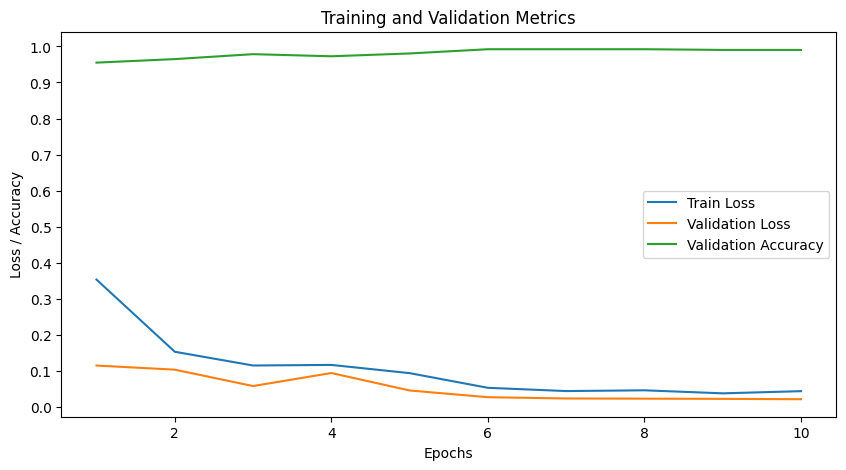

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), train_losses, label='Train Loss')
plt.plot(range(1, 11), val_losses, label='Validation Loss')
plt.plot(range(1, 11), accuracies, label='Validation Accuracy')
plt.yticks([y * 0.1 for y in range(11)])
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.title('Training and Validation Metrics')
plt.legend()
plt.show()